In [1]:
import random
import itertools as it
import time

import pandas as pd
import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

datasets = [dataset_A, dataset_B]

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset):
    node_cost = dataset["cost"].sum()
    distance_cost = sum(
        euclidean_distance(dataset.iloc[i], dataset.iloc[i + 1]) 
        for i in range(-1, len(dataset) - 1)
    )
    return int(node_cost + distance_cost)

In [8]:
def calculate_distance_matrix(dataset):
    n_nodes = len(dataset)
    distance_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    for i, j in it.product(range(n_nodes), range(n_nodes)):
        if i == j:
            continue
        a, b = dataset.iloc[i], dataset.iloc[j]
        distance_matrix[i, j] = euclidean_distance(a, b) + nodes_cost(a, b)
    return distance_matrix

In [9]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_B = calculate_distance_matrix(dataset_B)

In [10]:
print(f'objective function of node1 and node2 = {distance_matrix_A[177, 43]}')

objective function of node1 and node2 = 1831.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )
    

    
    plt.title(title)
    plt.show();

In [12]:
def experiment(dataset, distance_matrix, title, function, show_indices=False, **kwargs):
    start_time = time.time()
    ratings = []
    for i in range(200):
        greedy_cycle_solution = function(dataset, distance_matrix, i, **kwargs)
        solution = list(greedy_cycle_solution.index)
        ratings.append((solution, calculate_function_cost(greedy_cycle_solution)))

        if show_indices:
            print(i)

    best = sorted(ratings, key=lambda x: x[1])[0]
    minimum = sorted(ratings, key=lambda x: x[1])[0][1]
    mean = sum([obj_function for _, obj_function in ratings]) / len(ratings)
    maximum = sorted(ratings, key=lambda x: x[1])[-1][1]
    end_time = time.time()

    print(f"Best solution: {best[0]}")
    print(f"Time to calculate: {(end_time - start_time):.4f}")
    print("Objective function statistics:")
    print(f"{minimum = }\n{mean = }\n{maximum = }")
    plot(dataset, best[0], title=title)

# Local Search



In [13]:
def init_random_solution(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> pd.DataFrame:
    return dataset.sample(n=int(len(dataset) * 0.5 + 0.5))

In [14]:
def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    # Edges to be removed and added
    edges_removed = []
    edges_added = []

    # Remove edges connected to a and b
    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    # Calculate delta
    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta


def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    # Edges before and after reversal
    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta


def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    # Edge costs before and after the swap
    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    # Node costs before and after the swap
    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta

In [15]:
# Browse solutions

def browse_intra_solutions_with_candidates(
    dm: np.ndarray, solution: list, intra_search: str, candidate_moves: dict
) -> list:
    intra_neighbors = []
    n = len(solution)
    for i in range(n):
        if solution[i] not in candidate_moves:
            continue
        for j in range(i + 1, n):
            if solution[j] not in candidate_moves[solution[i]]:
                continue
            if intra_search == "node":
                delta_nodes = objective_change_two_nodes(dm, solution, i, j)
                if delta_nodes < 0:
                    intra_neighbors.append((i, j, delta_nodes, "node"))
            elif intra_search == "edge":
                delta_edges = objective_change_two_edges(dm, solution, i, j)
                if delta_edges < 0:
                    intra_neighbors.append((i, j, delta_edges, "edge"))
    return intra_neighbors


def browse_inter_solutions_with_candidates(
    dm: np.ndarray, solution: list, non_selected_nodes: set, costs: list, candidate_moves: dict
) -> list:
    inter_neighbors = []
    for i in range(len(solution)):
        if solution[i] not in candidate_moves:
            continue
        for vacant_node in non_selected_nodes:
            if vacant_node not in candidate_moves[solution[i]]:
                continue
            inter_delta = objective_change_inter_route(
                dm, solution, i, vacant_node, costs
            )
            if inter_delta < 0:
                inter_neighbors.append((i, vacant_node, inter_delta, "inter"))
    return inter_neighbors

In [16]:
def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution


def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()  # No change if i >= j

    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution


def inter_route_swap(solution, i, vacant_node, selected_nodes, non_selected_nodes):
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    # Update the node sets
    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes

In [17]:
def generate_intra_candidate_moves(solution, distance_matrix, candidates_number):
    intra_candidates = []
    n = len(solution)
    for i in range(n):
        node = solution[i]
        candidate_moves = []
        for j in range(n):
            if i != j:
                candidate = solution[j]
                delta = objective_change_two_edges(distance_matrix, solution, i, j)
                candidate_moves.append((delta, i, j))

        # Sort candidate moves by delta (improvement) and take the top candidates_number
        candidate_moves.sort()
        for delta, i, j in candidate_moves[:candidates_number]:
            if delta < 0:
                intra_candidates.append(("intra", i, j, delta))
    return intra_candidates

def generate_inter_candidate_moves(
    solution, distance_matrix, non_selected_nodes, node_costs, candidates_number
):
    inter_candidates = []
    n = len(solution)
    for i in range(n):
        node = solution[i]
        candidate_moves = []
        for candidate in non_selected_nodes:
            delta = objective_change_inter_route(
                distance_matrix, solution, i, candidate, node_costs
            )
            candidate_moves.append((delta, i, candidate))

        # Sort candidate moves by delta (improvement) and take the top candidates_number
        candidate_moves.sort()
        for delta, i, candidate in candidate_moves[:candidates_number]:
            if delta < 0:
                inter_candidates.append(("inter", i, candidate, delta))

    return inter_candidates

In [18]:
def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes


def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes


def local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    solution: list,
    strategy: str = "greedy",
    intra_search: str = "edge",
    debug_mode: bool = True,
    candidates_number: int = 10,
) -> pd.DataFrame:
    selected_nodes = set(solution)
    non_selected_nodes = set(range(len(dataset))) - selected_nodes
    node_costs = dataset['cost'].tolist()
    
    while True:
        intra_candidates = generate_intra_candidate_moves(solution, distance_matrix, candidates_number=candidates_number)
        inter_candidates = generate_inter_candidate_moves(solution, distance_matrix, non_selected_nodes, node_costs, candidates_number=candidates_number)
        all_candidates = intra_candidates + inter_candidates
        if not all_candidates:
            break
        # Choose the move with the best (most negative) delta
        best_move = min(all_candidates, key=lambda x: x[3])
        move_type, *move_params, delta = best_move
        if move_type == 'intra':
            idx1, idx2 = move_params
            solution = two_edges_exchange(solution, idx1, idx2)
        elif move_type == 'inter':
            idx, candidate = move_params
            solution, selected_nodes, non_selected_nodes = inter_route_swap(solution, idx, candidate, selected_nodes, non_selected_nodes)
        # Continue the loop
    return dataset.loc[solution]

In [19]:
def generate_candidate_moves(solution: list, dataset: pd.DataFrame, distance_matrix: np.ndarray, candidates_number: int = 10) -> dict:
    candidates = {}
    for node in solution:
        if node >= len(distance_matrix):
            continue
        distances = distance_matrix[node].copy()
        distances[node] = np.inf
        nearest_nodes = np.argsort(distances)[:candidates_number]
        candidates[node] = set(nearest_nodes)
    return candidates

In [20]:
def init_local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    start: int,
    strategy: str,
    intra_search: str,
    candidate_numbers: int,
    debug_mode: bool = True,
    algo_to_enchance: str = "greedy_cycle",
) -> pd.DataFrame:
    if algo_to_enchance == "random":
        solution = list(init_random_solution(dataset, distance_matrix, start).index)
    
    # assert all(0 <= node < len(distance_matrix) for node in solution)

    # candidate_moves = generate_candidate_moves(solution, dataset, distance_matrix, candidate_numbers)
    
    solution = local_search(dataset, distance_matrix, solution, strategy, intra_search, debug_mode, candidates_number=candidate_numbers)
    return solution

Random steepest edge results for:

Dataset A

Best solution: [78, 145, 25, 44, 120, 129, 2, 75, 86, 101, 1, 152, 97, 26, 53, 180, 154, 135, 70, 127, 123, 131, 149, 162, 133, 151, 51, 118, 59, 116, 65, 47, 43, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 34, 160, 42, 5, 115, 46, 139, 41, 193, 159, 181, 146, 22, 18, 108, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 148, 9, 62, 102, 49, 14, 144, 21, 164, 27, 90, 165, 40, 185, 106, 178, 52, 55, 57, 92, 179, 196, 81, 157, 31, 113, 175, 171, 16]

Time to calculate: 647.0512

Objective function statistics:

minimum = 71082

mean = 73892.495

maximum = 78058

Dataset B

Best solution: [20, 28, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 159, 41, 111, 82, 87, 21, 8, 104, 144, 0, 35, 109, 29, 160, 33, 138, 182, 11, 139, 168, 195, 145, 15, 189, 155, 3, 70, 161, 13, 132, 169, 188, 6, 134, 147, 51, 121, 90, 122, 133, 10, 107, 40, 63, 135, 38, 1, 117, 193, 31, 54, 73, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 79, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 180, 176, 194, 166, 86, 95, 185, 179, 94, 47, 148, 60, 23]

Time to calculate: 662.1826

Objective function statistics:

minimum = 45999

mean = 48257.715

maximum = 52107

### K = 10

Best solution: [78, 145, 25, 44, 120, 129, 2, 75, 86, 101, 1, 152, 97, 26, 53, 180, 154, 135, 70, 127, 123, 131, 149, 162, 133, 151, 51, 118, 59, 116, 65, 47, 43, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 34, 160, 42, 5, 115, 46, 139, 41, 193, 159, 181, 146, 22, 18, 108, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 148, 9, 62, 102, 49, 14, 144, 21, 164, 27, 90, 165, 40, 185, 106, 178, 52, 55, 57, 92, 179, 196, 81, 157, 31, 113, 175, 171, 16]
Time to calculate: 384.3271
Objective function statistics:
minimum = 71082
mean = 73892.495
maximum = 78058


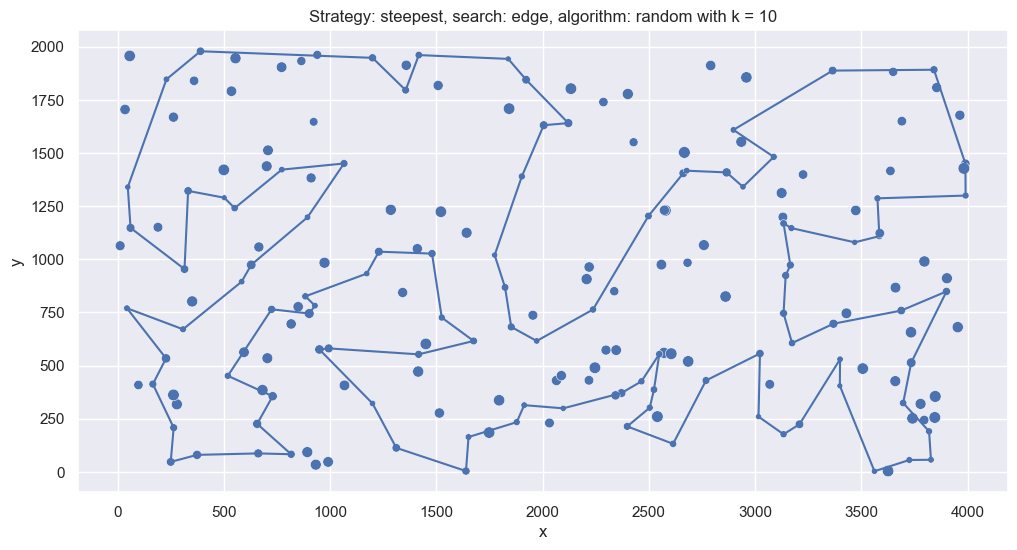

In [21]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_A,
    distance_matrix_A,
    f"Strategy: {strat}, search: {search}, algorithm: {algo} with k = 10",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 10,
    },
    show_indices = False,
)

Best solution: [20, 28, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 159, 41, 111, 82, 87, 21, 8, 104, 144, 0, 35, 109, 29, 160, 33, 138, 182, 11, 139, 168, 195, 145, 15, 189, 155, 3, 70, 161, 13, 132, 169, 188, 6, 134, 147, 51, 121, 90, 122, 133, 10, 107, 40, 63, 135, 38, 1, 117, 193, 31, 54, 73, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 79, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 180, 176, 194, 166, 86, 95, 185, 179, 94, 47, 148, 60, 23]
Time to calculate: 381.2334
Objective function statistics:
minimum = 45999
mean = 48257.715
maximum = 52107


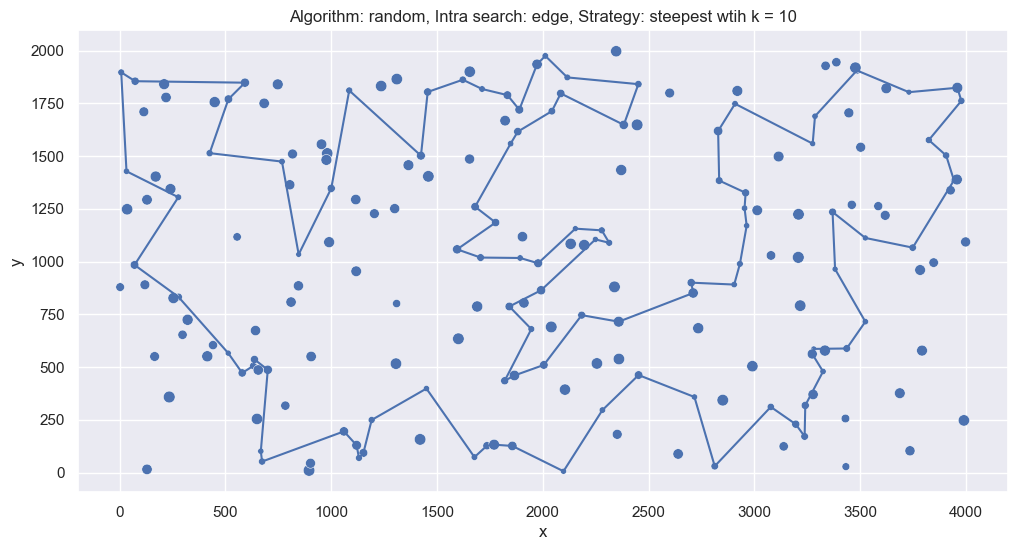

In [22]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} wtih k = 10",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 10,
    },
    show_indices = False,
)

### K = 20

Best solution: [84, 112, 123, 127, 70, 135, 154, 180, 158, 53, 121, 63, 94, 124, 152, 1, 97, 26, 100, 86, 101, 75, 2, 120, 44, 25, 16, 171, 175, 113, 31, 196, 81, 90, 165, 40, 185, 179, 145, 78, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 37, 148, 15, 186, 137, 23, 89, 183, 143, 170, 0, 117, 93, 140, 108, 18, 22, 146, 159, 193, 41, 139, 46, 115, 59, 118, 51, 176, 80, 79, 133, 151, 162, 149, 131, 47, 65, 116, 43, 5, 42, 181, 34, 160, 54, 177, 184]
Time to calculate: 405.8823
Objective function statistics:
minimum = 70957
mean = 73768.835
maximum = 77311


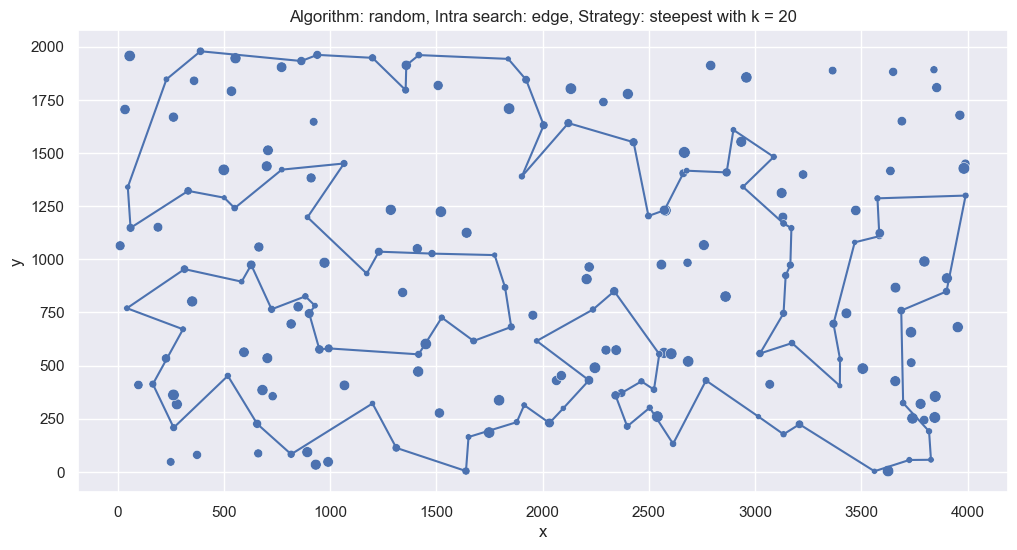

In [23]:
experiment(
    dataset_A,
    distance_matrix_A,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 20",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 20,
    },
    show_indices = False,
)

Best solution: [31, 54, 73, 190, 80, 162, 45, 175, 78, 5, 177, 104, 8, 82, 21, 61, 36, 91, 141, 77, 81, 153, 143, 106, 124, 128, 62, 18, 34, 55, 95, 130, 99, 22, 179, 185, 86, 176, 113, 103, 163, 89, 127, 137, 114, 194, 166, 172, 66, 94, 47, 148, 60, 20, 28, 149, 4, 199, 140, 183, 152, 184, 155, 3, 70, 15, 145, 29, 0, 109, 35, 111, 144, 160, 33, 138, 182, 11, 139, 168, 195, 13, 132, 169, 188, 6, 147, 10, 133, 107, 40, 63, 135, 122, 90, 191, 51, 121, 117, 193]
Time to calculate: 423.1775
Objective function statistics:
minimum = 45816
mean = 48277.31
maximum = 51400


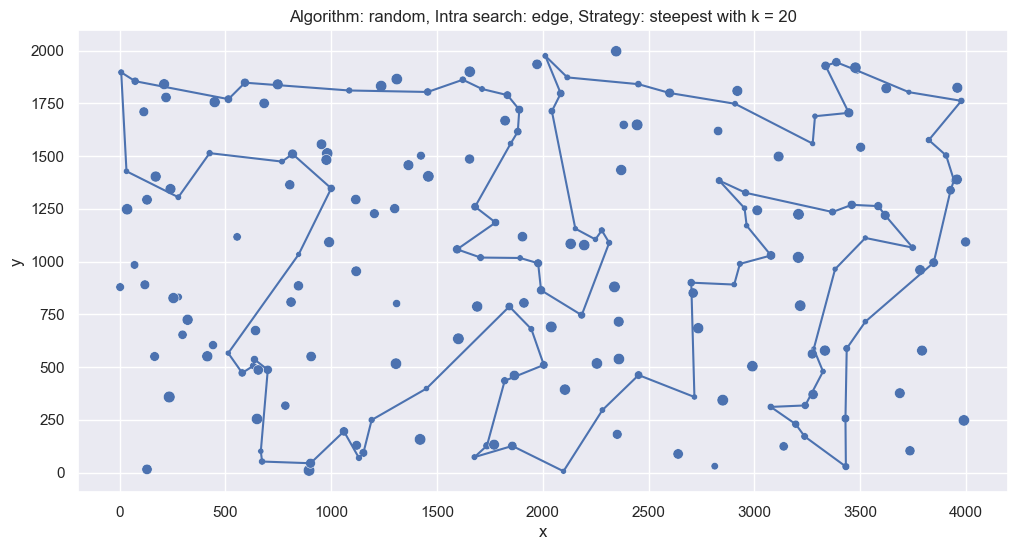

In [24]:
experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 20",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 20,
    },
    show_indices = False,
)

### K = 50

Best solution: [49, 144, 14, 178, 106, 185, 40, 119, 165, 39, 27, 90, 81, 196, 179, 52, 55, 57, 129, 92, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180, 154, 135, 70, 127, 112, 84, 184, 10, 177, 54, 160, 34, 181, 42, 43, 116, 65, 47, 131, 149, 123, 162, 151, 51, 118, 59, 115, 41, 193, 159, 146, 22, 18, 108, 139, 68, 46, 0, 143, 183, 89, 186, 23, 137, 176, 80, 133, 79, 63, 121, 189, 94, 124, 167, 148, 9, 62, 102]
Time to calculate: 423.7514
Objective function statistics:
minimum = 71196
mean = 74068.135
maximum = 78435


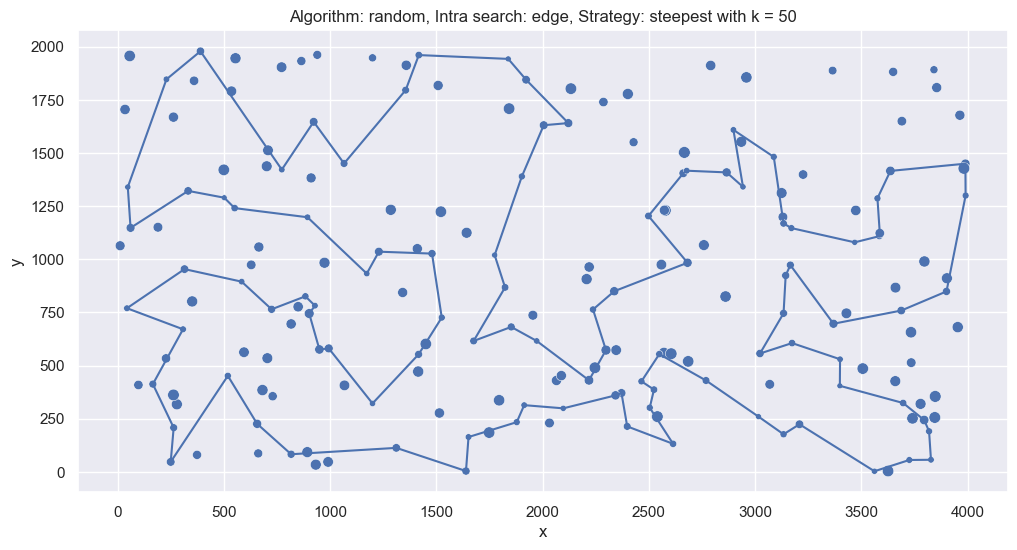

In [25]:
experiment(
    dataset_A,
    distance_matrix_A,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 50",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 50,
    },
    show_indices = False,
)

Best solution: [133, 10, 107, 40, 100, 63, 38, 27, 16, 1, 24, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 175, 78, 5, 36, 61, 91, 141, 77, 81, 153, 163, 89, 127, 137, 114, 103, 113, 176, 194, 166, 86, 95, 130, 99, 185, 179, 172, 66, 94, 47, 148, 20, 28, 149, 4, 140, 183, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 160, 33, 144, 104, 8, 82, 21, 177, 123, 25, 182, 138, 11, 139, 168, 195, 13, 145, 3, 70, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122]
Time to calculate: 425.6047
Objective function statistics:
minimum = 45536
mean = 48159.475
maximum = 51790


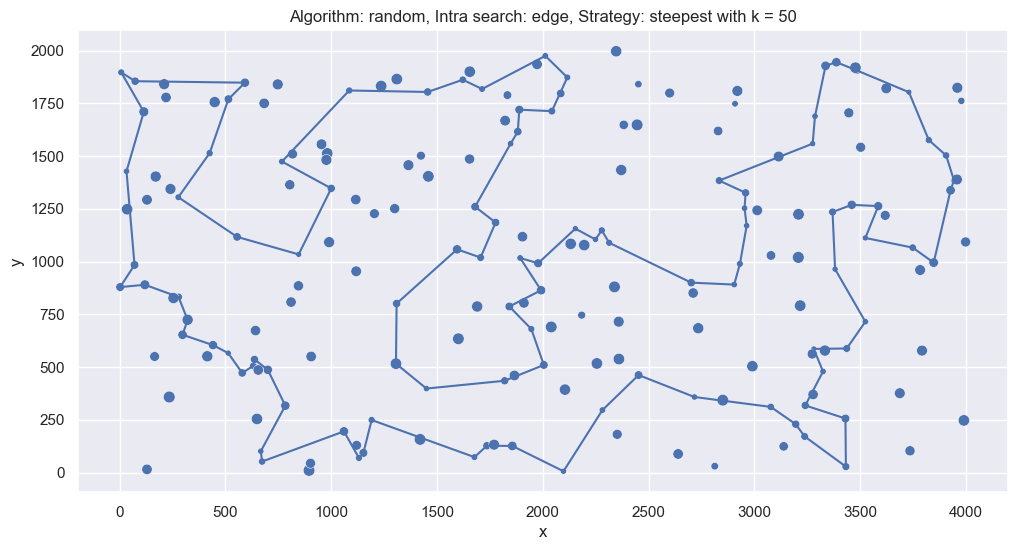

In [26]:
experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 50",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,  
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 50,
    },
    show_indices = False,
)